# Copy Task Plots

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
sys.path.append(os.path.abspath(os.getcwd() + "./../"))

%matplotlib inline

## Load training history

To generate the models and training history used in this notebook, run the following commands:

```
mkdir ./notebooks/copy
./train.py --seed 1 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 10 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 100 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 1000 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
```

In [3]:
!ls sort_new

 priority_sort-100-4-10-1-batch-10000.json
 priority_sort-100-4-10-1-batch-10000.model
 priority_sort-100-4-10-1-batch-1000.json
 priority_sort-100-4-10-1-batch-1000.model
 priority_sort-100-4-10-1-batch-10500.json
 priority_sort-100-4-10-1-batch-10500.model
 priority_sort-100-4-10-1-batch-11000.json
 priority_sort-100-4-10-1-batch-11000.model
 priority_sort-100-4-10-1-batch-11500.json
 priority_sort-100-4-10-1-batch-11500.model
 priority_sort-100-4-10-1-batch-12000.json
 priority_sort-100-4-10-1-batch-12000.model
 priority_sort-100-4-10-1-batch-12500.json
 priority_sort-100-4-10-1-batch-12500.model
 priority_sort-100-4-10-1-batch-13000.json
 priority_sort-100-4-10-1-batch-13000.model
 priority_sort-100-4-10-1-batch-13500.json
 priority_sort-100-4-10-1-batch-13500.model
 priority_sort-100-4-10-1-batch-14000.json
 priority_sort-100-4-10-1-batch-14000.model
 priority_sort-100-4-10-1-batch-14500.json
 priority_sort-100-4-10-1-batch-14500.model
 priority_sort-100-4-10-1-batch-15000.json
 p

In [4]:
batch_num = 50000
controller_size = 50
controller_layers = 4
seq_len = 5

files = glob("./sort_new/*-{}-*-{}-*-{}.json".format(controller_size,seq_len,batch_num))
files

['./sort_new/priority_sort-50-4-5-1-batch-50000.json']

In [5]:
# Read the metrics from the .json files
history = [json.loads(open(fname, "rt").read()) for fname in files]
training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
print("Training history (seed x metric x sequence) =", training.shape)

Training history (seed x metric x sequence) = (1, 3, 50000)


In [6]:
# Average every dv values across each (seed, metric)
dv = 500
training = training.reshape(len(files), 3, -1, dv).mean(axis=3)
print(training.shape)

(1, 3, 100)


In [7]:
# Average the seeds
training_mean = training.mean(axis=0)
training_std = training.std(axis=0)
print(training_mean.shape)
print(training_std.shape)

(3, 100)
(3, 100)


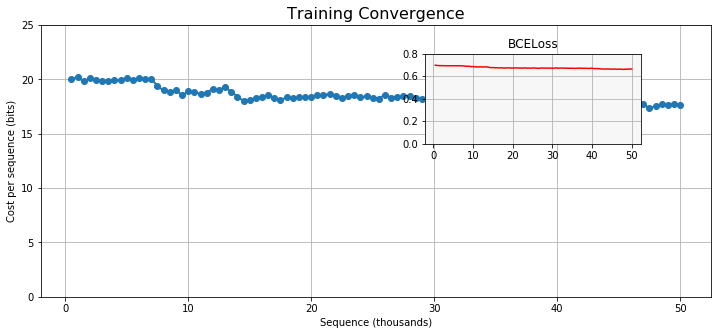

In [8]:
fig = plt.figure(figsize=(12, 5))

# X axis is normalized to thousands
x = np.arange(dv / 1000, (batch_num / 1000) + (dv / 1000), dv / 1000)

# Plot the cost
# plt.plot(x, training_mean[0], 'o-', linewidth=2, label='Cost')
plt.errorbar(x, training_mean[0], yerr=training_std[0], fmt='o-', elinewidth=2, linewidth=2, label='Cost')
plt.grid()
plt.yticks(np.arange(0, training_mean[0][0]+5, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Sequence (thousands)')
plt.title('Training Convergence', fontsize=16)

ax = plt.axes([.57, .55, .25, .25], facecolor=(0.97, 0.97, 0.97))
plt.title("BCELoss")
plt.plot(x, training_mean[1], 'r-', label='BCE Loss')
plt.yticks(np.arange(0, training_mean[1][0]+0.2, 0.2))
plt.grid()

plt.show()

In [32]:
from tqdm import trange, tqdm
from tasks.priority_sort import PrioritySortParams, PrioritySortModelTraining
#tqdm.jupyter()
batch_num = 50000
controller_size = 50
controller_layers = 4
seq_len = 5
params_num = {}
loss = {}
for controller_size in tqdm([50,100,200]):
    loss[controller_size] = {}
    params_num[controller_size] = {}
    model = PrioritySortModelTraining(params=PrioritySortParams(controller_type='Transformer', controller_size=controller_size))
    for seq_len in tqdm([5,7,10]):
        files = glob("./sort_new/*-{}-*-{}-*-{}.json".format(controller_size,seq_len,batch_num))
        if len(files)!=0:
            history = [json.loads(open(fname, "rt").read()) for fname in files]
            training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
            dv = 500
            training = training.reshape(len(files), 3, -1, dv).mean(axis=3)
            training_mean = training.mean(axis=0)
            training_std = training.std(axis=0)
            loss[controller_size][seq_len]  = training_mean[1]

100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


In [33]:
import json
import pickle
with open('training_loss.pickle','wb') as f:
    pickle.dump(loss,f)

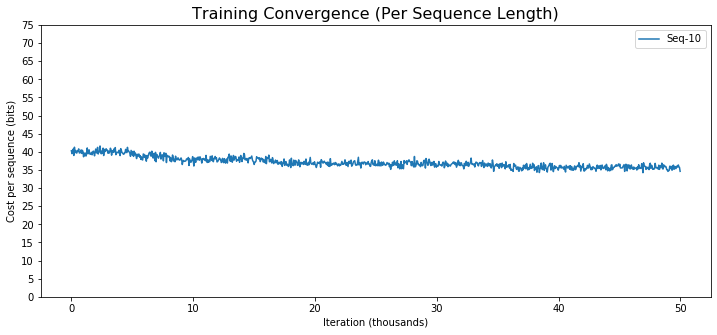

In [16]:
loss = history[0]['loss']
cost = history[0]['cost']
seq_lengths = history[0]['seq_lengths']

unique_sls = set(seq_lengths)
all_metric = list(zip(range(1, batch_num+1), seq_lengths, loss, cost))

fig = plt.figure(figsize=(12, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Iteration (thousands)')
plt.title('Training Convergence (Per Sequence Length)', fontsize=16)

for sl in unique_sls:
    sl_metrics = [i for i in all_metric if i[1] == sl]

    x = [i[0] for i in sl_metrics]
    y = [i[3] for i in sl_metrics]
    
    num_pts = len(x) // 50
    total_pts = num_pts * 50
    
    x_mean = [i.mean()/1000 for i in np.split(np.array(x)[:total_pts], num_pts)]
    y_mean = [i.mean() for i in np.split(np.array(y)[:total_pts], num_pts)]
    #40000
    plt.plot(x_mean, y_mean, label='Seq-{}'.format(sl))

plt.yticks(np.arange(0, 80, 5))
plt.legend(loc=0)
plt.show()

# Evaluate

In [17]:
import torch
from IPython.display import Image as IPythonImage
from PIL import Image, ImageDraw, ImageFont
import io
from tasks.copytask import dataloader
from train import evaluate

In [18]:
from tasks.priority_sort import PrioritySortParams, PrioritySortModelTraining
model = PrioritySortModelTraining(params=PrioritySortParams(controller_type='Transformer', controller_size=50))


In [19]:
batch_num = 50000
controller_size = 50
controller_layers = 4
seq_len = 5

model_name = glob("./sort_new/*-{}-*-{}-*-{}.model".format(controller_size,seq_len,batch_num))[0]
model_name

'./sort_new/priority_sort-50-4-5-1-batch-50000.model'

In [20]:
model

PrioritySortModelTraining(params=PrioritySortParams(name='priority_sort', controller_size=50, controller_layers=4, num_heads=1, sequence_width=8, sequence_len=20, memory_n=128, memory_m=20, num_batches=50000, batch_size=1, rmsprop_lr=0.0001, rmsprop_momentum=0.9, rmsprop_alpha=0.95, controller_type='Transformer', test_data=None), net=EncapsulatedNTM(
  (ntm): NTM(
    (controller): TransformerController(
      (pos_encoder): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): Linear(in_features=29, out_features=29, bias=True)
            )
            (linear1): Linear(in_features=29, out_features=2, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2, out_features=29, bias=True)
            (norm1): LayerNorm((29,), ep

In [21]:
model.net.load_state_dict(torch.load(model_name))
# import io

# with open(model_name,'rb') as f:
#     stream = io.BytesIO(f.tobytes()) 


<All keys matched successfully>

In [22]:
import pickle
#with open(../)

#test_data-contr_size-50-contr_layers-4-seqlen-7.pickle
#test_data_BIG-contr_size-100-contr_layers-4-seqlen-10.pickle
test_data_name = glob("../test_data-*-{}-*-{}-*-{}.pickle".format(controller_size, controller_layers,seq_len))[0]
test_data_name_BIG = glob("../test_data_BIG-*-{}-*-{}-*-{}.pickle".format(controller_size, controller_layers,seq_len*2))[0]

with open(test_data_name,'rb') as f:
    test_data = pickle.load(f)
    
with open(test_data_name_BIG,'rb') as f:
    test_data_big = pickle.load(f)
    

In [23]:
# seq_len = 60
# _, x, y = next(iter(dataloader(1, 1, 8, seq_len, seq_len, None)))


In [24]:
torch.split(torch.stack([torch.cat(x) for x in test_data.keys()]).transpose(0,1),200, dim=1)[0].shape

torch.Size([5, 200, 9])

In [25]:
[torch.cat(x) for x in test_data.keys()][0].shape

torch.Size([5, 9])

In [26]:
def evaluate(net, criterion, X, Y):
    """Evaluate a single batch (without training)."""
    inp_seq_len = X.size(0)
    outp_seq_len, batch_size, _ = Y.size()

    # New sequence
    net.init_sequence(batch_size)

    # Feed the sequence + delimiter
    states = []
    for i in range(inp_seq_len):
        o, state = net(X[i])
        states += [state]

    # Read the output (no input given)
    y_out = torch.zeros(Y.size())
    for i in range(outp_seq_len):
        y_out[i], state = net()
        states += [state]

    loss = criterion(y_out, Y)

    y_out_binarized = y_out.clone().data
    y_out_binarized.apply_(lambda x: 0 if x < 0.5 else 1)

    # The cost is the number of error bits per sequence
    cost = torch.sum(torch.abs(y_out_binarized - Y.data))
    #print(loss.data)
    result = {
        'loss': loss.data,#[0],
        'cost': cost / batch_size,
        'y_out': y_out,
        'y_out_binarized': y_out_binarized,
        'states': states
    }

    return result

In [27]:
#result = evaluate(model.net, model.criterion, test_data.keys(), list(test_data.values()))
result = evaluate(model.net, model.criterion, torch.split(torch.stack([torch.cat(x) for x in test_data.keys()]).transpose(0,1),50, dim=1)[0], torch.split(torch.stack([torch.cat(y) for y in test_data.values()]).transpose(0,1),50, dim=1)[0])

y_out = result['y_out']

/home/leon/anaconda3/envs/ntm/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [28]:
# from tqdm import trange
# batch_num = 50000
# controller_size = 50
# controller_layers = 4
# seq_len = 5
# losses = []
# losses_big = []
# for b_num in trange(0,50000,500):
#     model_name = glob("./sort_new/*-{}-*-{}-*-{}.model".format(controller_size,seq_len,batch_num))[0]
#     model.net.load_state_dict(torch.load(model_name))
#     losses.append(evaluate(model.net, model.criterion, torch.split(torch.stack([torch.cat(x) for x in test_data.keys()]).transpose(0,1),25, dim=1)[0], torch.split(torch.stack([torch.cat(y) for y in test_data.values()]).transpose(0,1),25, dim=1)[0])['loss'])
#     losses_big.append(evaluate(model.net, model.criterion, torch.split(torch.stack([torch.cat(x) for x in test_data_big.keys()]).transpose(0,1),25, dim=1)[0], torch.split(torch.stack([torch.cat(y) for y in test_data_big.values()]).transpose(0,1),25, dim=1)[0])['loss'])

In [29]:
from tqdm import trange, tqdm
#tqdm.jupyter()
batch_num = 50000
controller_size = 50
controller_layers = 4
seq_len = 5

data = {}
params_num = {}
for controller_size in tqdm([50,100,200]):
    data[controller_size] = {}
    params_num[controller_size] = {}
    model = PrioritySortModelTraining(params=PrioritySortParams(controller_type='Transformer', controller_size=controller_size))
    for seq_len in tqdm([5,7,10]):
        data[controller_size][seq_len] = {}
        #losses = []
        #losses_big = []
        for b_num in trange(0,50000,500):
            data[controller_size][seq_len][b_num] = {}
            if len(glob("./sort_new/*-{}-*-{}-*-{}.model".format(controller_size,seq_len,b_num)))>0:
                model_name = glob("./sort_new/*-{}-*-{}-*-{}.model".format(controller_size,seq_len,b_num))[0]
                model.net.load_state_dict(torch.load(model_name))
                test_loss = evaluate(model.net, model.criterion, torch.split(torch.stack([torch.cat(x) for x in test_data.keys()]).transpose(0,1),25, dim=1)[0], torch.split(torch.stack([torch.cat(y) for y in test_data.values()]).transpose(0,1),25, dim=1)[0])['loss']
                test_loss_big = evaluate(model.net, model.criterion, torch.split(torch.stack([torch.cat(x) for x in test_data_big.keys()]).transpose(0,1),25, dim=1)[0], torch.split(torch.stack([torch.cat(y) for y in test_data_big.values()]).transpose(0,1),25, dim=1)[0])['loss']
                #losses.append(test_loss)
                #losses_big.append(test_loss_big)
                
                data[controller_size][seq_len][b_num]['test_loss'] = test_loss
                data[controller_size][seq_len][b_num]['test_loss_big'] = test_loss_big
                
                params_num[controller_size] = model.net.calculate_num_params()
                

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:01<01:25,  1.15it/s]

  3%|▎         | 3/100 [00:03<01:46,  1.10s/it]

  4%|▍         | 4/100 [00:04<01:59,  1.24s/it]

  5%|▌         | 5/100 [00:06<02:14,  1.42s/it]

  6%|▌         | 6/100 [00:08<02:17,  1.46s/it]

  7%|▋         | 7/100 [00:09<02:15,  1.46s/it]

  8%|▊         | 8/100 [00:11<02:15,  1.47s/it]

  9%|▉         | 9/100 [00:12<02:17,  1.51s/it]

 10%|█         | 10/100 [00:14<02:18,  1.54s/it]

 11%|█         | 11/100 [00:16<02:16,  1.54s/it]

 12%|█▏        | 12/100 [00:17<02:17,  1.56s/it]

 13%|█▎        | 13/100 [00:19<02:15,  1.56s/it]

 14%|█▍        | 14/100 [00:20<02:13,  1.55s/it]

 15%|█▌        | 15/100 [00:22<02:16,  1.61s/it]

 16%|█▌        | 16/100 [00:24<02:15,  1.61s/it]

 17%|█▋        | 17/100 [00:25<02:13,  1.61s/it]

 18%|█▊        | 18/100 [00:27<02:12,  1.61s/it]

 19%|█▉        | 19/100 [00:28<02:08,  1.59s/it]

 20%|██        | 20/100 [00:

 45%|████▌     | 45/100 [01:29<01:51,  2.03s/it]

 46%|████▌     | 46/100 [01:31<01:48,  2.01s/it]

 47%|████▋     | 47/100 [01:33<01:46,  2.02s/it]

 48%|████▊     | 48/100 [01:35<01:45,  2.04s/it]

 49%|████▉     | 49/100 [01:37<01:42,  2.01s/it]

 50%|█████     | 50/100 [01:39<01:39,  2.00s/it]

 51%|█████     | 51/100 [01:41<01:38,  2.00s/it]

 52%|█████▏    | 52/100 [01:43<01:36,  2.00s/it]

 53%|█████▎    | 53/100 [01:45<01:33,  1.99s/it]

 54%|█████▍    | 54/100 [01:47<01:31,  2.00s/it]

 55%|█████▌    | 55/100 [01:49<01:29,  1.98s/it]

 56%|█████▌    | 56/100 [01:51<01:27,  1.98s/it]

 57%|█████▋    | 57/100 [01:53<01:25,  1.99s/it]

 58%|█████▊    | 58/100 [01:55<01:23,  1.98s/it]

 59%|█████▉    | 59/100 [01:57<01:21,  1.98s/it]

 60%|██████    | 60/100 [01:59<01:19,  1.99s/it]

 61%|██████    | 61/100 [02:01<01:23,  2.14s/it]

 62%|██████▏   | 62/100 [02:03<01:19,  2.09s/it]

 63%|██████▎   | 63/100 [02:05<01:16,  2.05s/it]

 64%|██████▍   | 64/100 [02:07<01:13,  2.03s/it]



 90%|█████████ | 90/100 [03:17<00:23,  2.32s/it]

 91%|█████████ | 91/100 [03:21<00:23,  2.60s/it]

 92%|█████████▏| 92/100 [03:23<00:20,  2.50s/it]

 93%|█████████▎| 93/100 [03:25<00:17,  2.48s/it]

 94%|█████████▍| 94/100 [03:27<00:13,  2.33s/it]

 95%|█████████▌| 95/100 [03:29<00:11,  2.26s/it]

 96%|█████████▌| 96/100 [03:32<00:08,  2.22s/it]

 97%|█████████▋| 97/100 [03:34<00:06,  2.15s/it]

 98%|█████████▊| 98/100 [03:36<00:04,  2.33s/it]

 99%|█████████▉| 99/100 [03:39<00:02,  2.58s/it]

100%|██████████| 100/100 [03:43<00:00,  2.23s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:03<02:41,  1.65s/it]

  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

  4%|▍         | 4/100 [00:09<03:43,  2.33s/it]

  5%|▌         | 5/100 [00:11<03:40,  2.32s/it]

  6%|▌         | 6/100 [00:13<03:30,  2.24s/it]

  7%|▋         | 7/100 [00:15<03:28,  2.24s/it]

  8%|▊         | 8/100 [00:18<03:22,  2.21s/it]

  9%|▉         | 9/100 [00

 33%|███▎      | 33/100 [01:06<02:22,  2.12s/it]

 34%|███▍      | 34/100 [01:09<02:33,  2.33s/it]

 35%|███▌      | 35/100 [01:11<02:29,  2.31s/it]

 36%|███▌      | 36/100 [01:13<02:22,  2.23s/it]

 37%|███▋      | 37/100 [01:15<02:15,  2.15s/it]

 38%|███▊      | 38/100 [01:17<02:11,  2.13s/it]

 39%|███▉      | 39/100 [01:20<02:08,  2.11s/it]

 40%|████      | 40/100 [01:21<02:03,  2.06s/it]

 41%|████      | 41/100 [01:24<02:01,  2.06s/it]

 42%|████▏     | 42/100 [01:25<01:57,  2.03s/it]

 43%|████▎     | 43/100 [01:28<01:56,  2.05s/it]

 44%|████▍     | 44/100 [01:30<01:58,  2.12s/it]

 45%|████▌     | 45/100 [01:32<01:57,  2.13s/it]

 46%|████▌     | 46/100 [01:34<01:55,  2.13s/it]

 47%|████▋     | 47/100 [01:37<02:01,  2.29s/it]

 48%|████▊     | 48/100 [01:39<01:56,  2.24s/it]

 49%|████▉     | 49/100 [01:41<01:58,  2.31s/it]

 50%|█████     | 50/100 [01:44<01:54,  2.29s/it]

 51%|█████     | 51/100 [01:46<01:55,  2.35s/it]

 52%|█████▏    | 52/100 [01:48<01:50,  2.31s/it]



 78%|███████▊  | 78/100 [03:06<00:56,  2.56s/it]

 79%|███████▉  | 79/100 [03:09<00:51,  2.47s/it]

 80%|████████  | 80/100 [03:11<00:50,  2.52s/it]

 81%|████████  | 81/100 [03:13<00:46,  2.42s/it]

 82%|████████▏ | 82/100 [03:16<00:42,  2.34s/it]

 83%|████████▎ | 83/100 [03:18<00:38,  2.28s/it]

 84%|████████▍ | 84/100 [03:20<00:35,  2.25s/it]

 85%|████████▌ | 85/100 [03:22<00:35,  2.34s/it]

 86%|████████▌ | 86/100 [03:25<00:32,  2.30s/it]

 87%|████████▋ | 87/100 [03:27<00:29,  2.24s/it]

 88%|████████▊ | 88/100 [03:29<00:27,  2.29s/it]

 89%|████████▉ | 89/100 [03:32<00:25,  2.34s/it]

 90%|█████████ | 90/100 [03:34<00:23,  2.33s/it]

 91%|█████████ | 91/100 [03:36<00:20,  2.31s/it]

 92%|█████████▏| 92/100 [03:38<00:18,  2.27s/it]

 93%|█████████▎| 93/100 [03:41<00:15,  2.29s/it]

 94%|█████████▍| 94/100 [03:43<00:13,  2.31s/it]

 95%|█████████▌| 95/100 [03:45<00:11,  2.29s/it]

 96%|█████████▌| 96/100 [03:47<00:08,  2.24s/it]

 97%|█████████▋| 97/100 [03:50<00:06,  2.25s/it]



 21%|██        | 21/100 [00:44<03:02,  2.31s/it]

 22%|██▏       | 22/100 [00:46<02:58,  2.29s/it]

 23%|██▎       | 23/100 [00:48<02:53,  2.25s/it]

 24%|██▍       | 24/100 [00:50<02:46,  2.19s/it]

 25%|██▌       | 25/100 [00:52<02:41,  2.16s/it]

 26%|██▌       | 26/100 [00:54<02:36,  2.12s/it]

 27%|██▋       | 27/100 [00:56<02:32,  2.09s/it]

 28%|██▊       | 28/100 [00:58<02:31,  2.10s/it]

 29%|██▉       | 29/100 [01:00<02:29,  2.10s/it]

 30%|███       | 30/100 [01:03<02:30,  2.15s/it]

 31%|███       | 31/100 [01:05<02:26,  2.13s/it]

 32%|███▏      | 32/100 [01:07<02:24,  2.12s/it]

 33%|███▎      | 33/100 [01:09<02:24,  2.15s/it]

 34%|███▍      | 34/100 [01:11<02:21,  2.15s/it]

 35%|███▌      | 35/100 [01:13<02:18,  2.13s/it]

 36%|███▌      | 36/100 [01:16<02:16,  2.13s/it]

 37%|███▋      | 37/100 [01:18<02:14,  2.14s/it]

 38%|███▊      | 38/100 [01:20<02:17,  2.22s/it]

 39%|███▉      | 39/100 [01:22<02:14,  2.21s/it]

 40%|████      | 40/100 [01:24<02:10,  2.18s/it]



 66%|██████▌   | 66/100 [02:30<01:28,  2.59s/it]

 67%|██████▋   | 67/100 [02:33<01:24,  2.56s/it]

 68%|██████▊   | 68/100 [02:35<01:18,  2.45s/it]

 69%|██████▉   | 69/100 [02:37<01:12,  2.35s/it]

 70%|███████   | 70/100 [02:39<01:08,  2.28s/it]

 71%|███████   | 71/100 [02:42<01:06,  2.31s/it]

 72%|███████▏  | 72/100 [02:44<01:06,  2.37s/it]

 73%|███████▎  | 73/100 [02:46<01:02,  2.30s/it]

 74%|███████▍  | 74/100 [02:49<00:58,  2.26s/it]

 75%|███████▌  | 75/100 [02:51<00:55,  2.21s/it]

 76%|███████▌  | 76/100 [02:53<00:53,  2.24s/it]

 77%|███████▋  | 77/100 [02:55<00:51,  2.24s/it]

 78%|███████▊  | 78/100 [02:57<00:48,  2.22s/it]

 79%|███████▉  | 79/100 [02:59<00:45,  2.19s/it]

 80%|████████  | 80/100 [03:02<00:44,  2.21s/it]

 81%|████████  | 81/100 [03:04<00:44,  2.32s/it]

 82%|████████▏ | 82/100 [03:07<00:44,  2.45s/it]

 83%|████████▎ | 83/100 [03:10<00:41,  2.45s/it]

 84%|████████▍ | 84/100 [03:12<00:40,  2.51s/it]

 85%|████████▌ | 85/100 [03:14<00:36,  2.44s/it]



In [30]:
params_num

{50: 21732, 100: 28232, 200: 41232}

In [31]:
import json
with open('test_results.pickle','wb') as f:
    pickle.dump(data,f)

/home/leon/anaconda3/envs/ntm/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [25]:
result['loss']

tensor(0.6735)

In [50]:
def cmap(value):
    pixval = value * 255
    low = 64
    high = 240
    factor = (255 - low - (255-high)) / 255
    return int(low + pixval * factor)

def draw_sequence(y, u=12):
    seq_len = y.size(0)
    seq_width = y.size(2)
    inset = u // 8
    pad = u // 2
    width = seq_len * u + 2 * pad
    height = seq_width * u + 2 * pad
    im = Image.new('L', (width, height))
    draw = ImageDraw.ImageDraw(im)
    draw.rectangle([0, 0, width, height], fill=250)
    for i in range(seq_len):
        for j in range(seq_width):
            val = 1 - y[i, 0, j]#.data[0]
            draw.rectangle([pad + i*u + inset,
                            pad + j*u + inset,
                            pad + (i+1)*u - inset,
                            pad + (j+1)*u - inset], fill=cmap(val))

    return im

def im_to_png_bytes(im):
    png = io.BytesIO()
    im.save(png, 'PNG')
    return bytes(png.getbuffer())

def im_vconcat(im1, im2, pad=8):
    assert im1.size == im2.size
    w, h = im1.size

    width = w
    height = h * 2 + pad

    im = Image.new('L', (width, height), color=255)
    im.paste(im1, (0, 0))
    im.paste(im2, (0, h+pad))
    return im

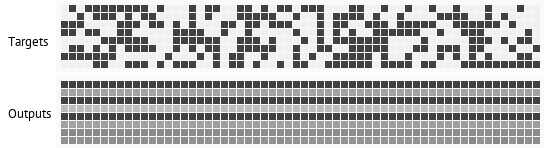

In [51]:
def make_eval_plot(y, y_out, u=12):
    im_y = draw_sequence(y, u)
    im_y_out = draw_sequence(y_out, u)
    im = im_vconcat(im_y, im_y_out, u//2)
    
    w, h = im.size
    pad_w = u * 7
    im2 = Image.new('L', (w+pad_w, h), color=255)
    im2.paste(im, (pad_w, 0))
    
    # Add text
    font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
    draw = ImageDraw.ImageDraw(im2)
    draw.text((u,4*u), "Targets", font=font)
    draw.text((u,13*u), "Outputs", font=font)
    
    return im2

im = make_eval_plot(y, y_out, u=8)
IPythonImage(im_to_png_bytes(im))

## Create an animated GIF

Lets see how the prediction looks like in each checkpoint that we saved. 

In [30]:
seq_len = 80
_, x, y = next(iter(dataloader(1, 1, 8, seq_len, seq_len)))

frames = []
font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
for batch_num in range(500, 10500, 500):
    model = CopyTaskModelTraining()
    model.net.load_state_dict(torch.load("./copy_l/copy-task-1-batch-{}.model".format(batch_num)))
    result = evaluate(model.net, model.criterion, x, y)
    y_out = result['y_out']
    frame = make_eval_plot(y, y_out, u=10)
    
    w, h = frame.size
    frame_seq = Image.new('L', (w, h+40), color=255)
    frame_seq.paste(frame, (0, 40))
    
    draw = ImageDraw.ImageDraw(frame_seq)
    draw.text((10, 10), "Sequence Num: {} (Cost: {})".format(batch_num, result['cost']), font=font)
    
    frames += [frame_seq]

In [76]:
im = frames[0]
im.save("./copy_l-train-80.gif", save_all=True, append_images=frames[1:], loop=0, duration=1000)

im = frames[0]
im.save("./copy-l-train-80-fast.gif", save_all=True, append_images=frames[1:], loop=0, duration=100)